In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

from sae_lens import SAE


In [2]:
def get_sae_features(text, model, tokenizer, sae, layer, device):
    """
    Extract SAE features for a given input
    """
    activations = {}

    def hook_fn(module, input, output):
        hidden_states = output[0] if isinstance(output, tuple) else output
        activations['hidden_states'] = hidden_states.detach()
    # hook to the layer
    handle = model.model.layers[layer].register_forward_hook(hook_fn)

    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        model(**inputs)
    # why?
    handle.remove()

    feature_activations = sae.encode(activations['hidden_states'])

    rt = {
        "feature_activations": feature_activations,
        "input_ids": inputs["input_ids"],
        "input_tokens": tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]),
        "hidden_states": activations['hidden_states']
    }

    return rt


In [3]:
device = 'cuda:7' if torch.cuda.is_available() else 'cpu'

model_id = "google/gemma-2-2b"

model = AutoModelForCausalLM.from_pretrained(model_id, output_hidden_states=True).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.eval()

print(f"loaded model {model_id} on {device}")

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 89.66it/s]


loaded model google/gemma-2-2b on cuda:7


In [4]:
release_id = "gemma-scope-2b-pt-mlp-canonical"
sae_id = "layer_12/width_16k/canonical"

# load SAE
sae = SAE.from_pretrained(
    release=release_id,
    sae_id=sae_id,
    device=device
)

print(f"loaded SAE {sae_id} on {device}")

loaded SAE layer_12/width_16k/canonical on cuda:7


### test run

In [5]:
import json


with open('topiocqa.json') as f:
    data = json.load(f)

num_conv = 5

# convs = [i for i in data if int(list(i.keys())[0].split('_')[0]) < num_conv]
# convs

In [6]:
l_id = None

inputs = {}
activations = {}

for i in data:
    c_id = int(list(i.keys())[0].split('_')[0])
    text = i[list(i.keys())[0]]['prompt']

    if c_id <= num_conv:

        if c_id not in activations and c_id != l_id:
            inputs[c_id] = []
            activations[c_id] = []

        rt = get_sae_features(text, model, tokenizer, sae, 12, device)
        inputs[c_id].append(rt['hidden_states'][0, -1, : ])
        activations[c_id].append(rt['feature_activations'][0, -1, : ])

        l_id = c_id


In [7]:
# activations

In [9]:
import torch.nn.functional as F


def compute_similarity_matrices(acts):
    sim_dict = {}

    for idx, vectors in acts.items():
        if len(vectors) == 0:
            sim_dict[idx] = None
            continue
        # stack into (N, D)
        X = torch.stack(vectors, dim=0)
        # optional: detach if you don't want gradients
        X = X.detach()
        # normalize (safe for cosine similarity)
        X = F.normalize(X, dim=1, eps=1e-8)

        # cosine similarity matrix: (N, N)
        sim = X @ X.T

        sim_dict[idx] = sim

    return sim_dict

In [10]:
act_similarity = compute_similarity_matrices(activations)

in_similarity = compute_similarity_matrices(inputs)


In [11]:
import matplotlib.pyplot as plt


def plot_sim(sim):
    if isinstance(sim, torch.Tensor):
        sim = sim.detach().cpu()

    plt.imshow(sim, cmap="viridis")
    plt.colorbar()
    plt.title("cosine similarity")

    # add values in each cell
    for i in range(sim.shape[0]):
        for j in range(sim.shape[1]):
            plt.text(
                j, i,
                f"{sim[i, j]:.2f}",
                ha="center",
                va="center",
                color="black",
                fontsize=7 
            )

    plt.show()

In [68]:
torch.save(activations, "activations.pt")

# activations = torch.load("activations.pt")


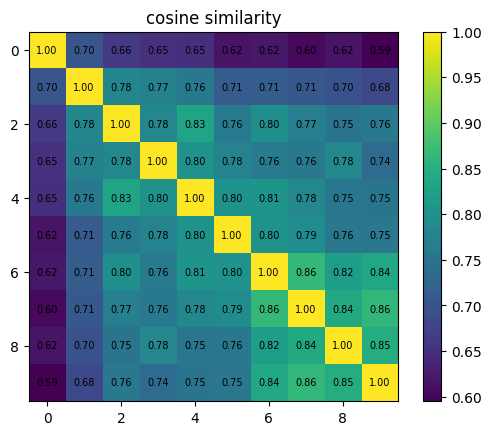

In [12]:
plot_sim(act_similarity[5])

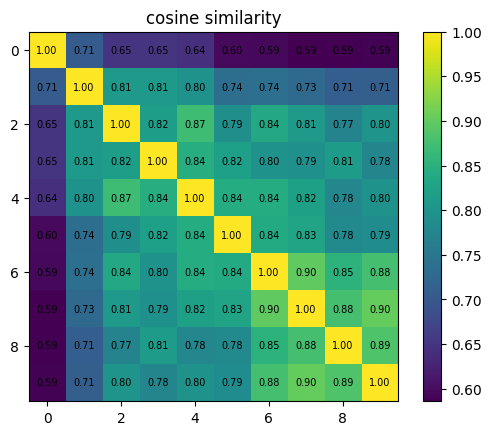

In [13]:
plot_sim(in_similarity[5])